In [1]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

In [2]:
import torch
import numpy as np
import random

def set_seed(seed=42):
    """Sets random seed for reproducibility."""
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

set_seed()

In [3]:
csv_path = r"C:\Users\user\OneDrive\Desktop\PROJECT\GitHub\Baby-Movement-Detection\baby_movement_dataset.csv"
print("Using CSV:", csv_path)


Using CSV: C:\Users\user\OneDrive\Desktop\PROJECT\GitHub\Baby-Movement-Detection\baby_movement_dataset.csv


In [4]:
# read csv and quick sanity checks
df = pd.read_csv(csv_path)
print("Rows:", len(df))
print(df.head())

# Ensure columns exist (adjust names if different)
expected_cols = ['image_path', 'label']
if not set(expected_cols).issubset(df.columns):
    print("CSV columns:", df.columns.tolist())
    raise ValueError("CSV must contain columns: 'image_path' and 'label'")

# Show count per class
print(df['label'].value_counts())


Rows: 1200
                                          image_path          label
0  frames/baby_crawling/baby_crawling_video10_fra...  baby_crawling
1  frames/baby_crawling/baby_crawling_video10_fra...  baby_crawling
2  frames/baby_crawling/baby_crawling_video10_fra...  baby_crawling
3  frames/baby_crawling/baby_crawling_video10_fra...  baby_crawling
4  frames/baby_crawling/baby_crawling_video10_fra...  baby_crawling
label
baby_crawling    300
baby_lying       300
baby_sitting     300
baby_standing    300
Name: count, dtype: int64


In [5]:
# fix image paths so they point to where your frames are in Drive.
# You said you uploaded images and csv to Drive. If image_path is already a full path, keep it.
# Otherwise assume paths are relative to a folder you uploaded to Drive: e.g. /content/drive/MyDrive/Baby-Movement-Detection/frames/

# EDIT this to your Drive frames folder if needed (common default below)
drive_frames_root = r"C:\Users\user\OneDrive\Desktop\PROJECT\GitHub\Baby-Movement-Detection\frames"

def make_full_path(p):
    # If path is already absolute and exists, return it
    if os.path.isabs(p) and os.path.exists(p):
        return p
    # if it was uploaded into the Colab environment with absolute path /mnt/data/..., leave as is if exists
    candidate1 = p
    if os.path.exists(candidate1):
        return candidate1
    # try combined with drive_frames_root
    candidate2 = os.path.join(drive_frames_root, p)
    if os.path.exists(candidate2):
        return candidate2
    # try path as inside MyDrive root (in case csv stored relative to Drive root)
    candidate3 = os.path.join("/content/drive/MyDrive", p)
    if os.path.exists(candidate3):
        return candidate3
    # fallback to original (may error later)
    return p

# Apply mapping and check how many files are found
df['full_path'] = df['image_path'].apply(make_full_path)
missing = df[~df['full_path'].apply(os.path.exists)]
print("Missing files count:", len(missing))
if len(missing) > 0:
    print("Examples of missing paths (first 10):")
    print(missing[['image_path','full_path']].head(10))
    # Don't raise here; if everything is inside drive_frames_root and naming matches, you can edit drive_frames_root above.
else:
    print("All file paths exist.")


Missing files count: 0
All file paths exist.


In [6]:
# split dataset and build tf.data pipeline
from sklearn.model_selection import train_test_split

# Split into train/val/test
train_df, temp_df = train_test_split(df, test_size=0.25, stratify=df['label'], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['label'], random_state=42)

print("Train:", len(train_df), "Val:", len(val_df), "Test:", len(test_df))

# Parameters
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE

# Helper to build dataset from a dataframe
def df_to_dataset(dataframe, shuffle=True, batch_size=BATCH_SIZE):
    file_paths = dataframe['full_path'].values
    labels = dataframe['label'].values
    # convert labels to integer indices
    classes = sorted(dataframe['label'].unique())  # note: only returns classes present in this split
    # But we need a global mapping:
    return file_paths, labels

# Build global class mapping from full dataset
class_names = sorted(df['label'].unique())
class_to_idx = {c:i for i,c in enumerate(class_names)}
print("Classes:", class_names)

def paths_labels_to_dataset(paths, labels, shuffle=True):
    # Convert labels (strings) to ints
    labels_int = np.array([class_to_idx[l] for l in labels])
    ds = tf.data.Dataset.from_tensor_slices((paths, labels_int))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(paths), reshuffle_each_iteration=True)
    def _load_image(path, label):
        image = tf.io.read_file(path)
        image = tf.image.decode_jpeg(image, channels=3)  # or decode_image
        image = tf.image.resize(image, IMG_SIZE)
        image = tf.cast(image, tf.float32) / 255.0
        return image, label
    ds = ds.map(_load_image, num_parallel_calls=AUTOTUNE)
    ds = ds.batch(batch_size=BATCH_SIZE).prefetch(AUTOTUNE)
    return ds

train_ds = paths_labels_to_dataset(train_df['full_path'].values, train_df['label'].values, shuffle=True)
val_ds   = paths_labels_to_dataset(val_df['full_path'].values, val_df['label'].values, shuffle=False)
test_ds  = paths_labels_to_dataset(test_df['full_path'].values, test_df['label'].values, shuffle=False)


Train: 900 Val: 150 Test: 150
Classes: ['baby_crawling', 'baby_lying', 'baby_sitting', 'baby_standing']


In [7]:
#  augmentation
data_augmentation = keras.Sequential([
    keras.layers.RandomFlip("horizontal"),
    keras.layers.RandomRotation(0.05),
    keras.layers.RandomTranslation(0.05, 0.05),
    keras.layers.RandomZoom(0.05),
], name="data_augmentation")


In [8]:
# build model
base_model = keras.applications.ResNet50(
    weights="imagenet",
    include_top=False,
    input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)
)

base_model.trainable = False  # freeze for initial training

inputs = keras.Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
x = data_augmentation(inputs)
x = keras.applications.resnet.preprocess_input(x * 255.0)  # preprocess_input expects 0..255
x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.3)(x)
outputs = keras.layers.Dense(len(class_names), activation="softmax")(x)

model = keras.Model(inputs, outputs)
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()


A local file was found, but it seems to be incomplete or outdated because the auto file hash does not match the original value of 4d473c1dd8becc155b73f8504c6f6626 so we will re-download the data.
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 74s 1us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ data_augmentation   │ (None, 224, 224,  │          0 │ input_layer_1[0]… │
│ (Sequential)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply (Multiply) │ (None, 224, 224,  │          0 │ data_augmentatio… │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item (GetItem)  │ (None, 224, 224)  │          0 │ multiply[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_1          │ (None, 224, 224)  │          0 │ multiply[0][0]    │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_2          │ (None, 224, 224)  │          0 │ multiply[0][0]    │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack (Stack)       │ (None, 224, 224,  │          0 │ get_item[0][0],   │
│                     │ 3)                │            │ get_item_1[0][0], │
│                     │                   │            │ get_item_2[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 224, 224,  │          0 │ stack[0][0]       │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resnet50            │ (None, 7, 7,      │ 23,587,712 │ add[0][0]         │
│ (Functional)        │ 2048)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 2048)      │          0 │ resnet50[0][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 2048)      │          0 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 4)         │      8,196 │ dropout[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 23,595,908 (90.01 MB)

 Trainable params: 8,196 (32.02 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [ ]:
# callbacks and class weights
from collections import Counter
counts = Counter(train_df['label'].tolist())
print("Train class counts:", counts)

# compute class weights to balance if dataset imbalanced
total = sum(counts.values())
class_weight = {class_to_idx[c]: total/ (len(class_names) * cnt) for c, cnt in counts.items()}
print("Class weights:", class_weight)

checkpoint_path = r"C:\Users\user\OneDrive\Desktop\PROJECT\GitHub\Baby-Movement-Detection\baby_movement_resnet50_best.h5"
callbacks = [
    keras.callbacks.ModelCheckpoint(checkpoint_path, monitor="val_accuracy", save_best_only=True, verbose=1),
    keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, min_lr=1e-6, verbose=1),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=8, restore_best_weights=True, verbose=1)
]

Train class counts: Counter({'baby_sitting': 225, 'baby_lying': 225, 'baby_standing': 225, 'baby_crawling': 225})
Class weights: {2: 1.0, 1: 1.0, 3: 1.0, 0: 1.0}


In [10]:
#  train head only
EPOCHS_HEAD = 10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS_HEAD,
    callbacks=callbacks,
    class_weight=class_weight
)


Epoch 1/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.4917 - loss: 1.2462
Epoch 1: val_accuracy improved from None to 0.85333, saving model to /content/drive/MyDrive/baby_movement_resnet50_best.h5


29/29 ━━━━━━━━━━━━━━━━━━━━ 232s 7s/step - accuracy: 0.6167 - loss: 0.9631 - val_accuracy: 0.8533 - val_loss: 0.4649 - learning_rate: 0.0010
Epoch 2/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.8767 - loss: 0.3796
Epoch 2: val_accuracy improved from 0.85333 to 0.88667, saving model to /content/drive/MyDrive/baby_movement_resnet50_best.h5


29/29 ━━━━━━━━━━━━━━━━━━━━ 257s 9s/step - accuracy: 0.8867 - loss: 0.3364 - val_accuracy: 0.8867 - val_loss: 0.2655 - learning_rate: 0.0010
Epoch 3/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.9051 - loss: 0.2626
Epoch 3: val_accuracy improved from 0.88667 to 0.95333, saving model to /content/drive/MyDrive/baby_movement_resnet50_best.h5


29/29 ━━━━━━━━━━━━━━━━━━━━ 232s 8s/step - accuracy: 0.9256 - loss: 0.2288 - val_accuracy: 0.9533 - val_loss: 0.1713 - learning_rate: 0.0010
Epoch 4/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.9544 - loss: 0.1508
Epoch 4: val_accuracy improved from 0.95333 to 0.97333, saving model to /content/drive/MyDrive/baby_movement_resnet50_best.h5


29/29 ━━━━━━━━━━━━━━━━━━━━ 230s 8s/step - accuracy: 0.9522 - loss: 0.1554 - val_accuracy: 0.9733 - val_loss: 0.1256 - learning_rate: 0.0010
Epoch 5/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.9622 - loss: 0.1339
Epoch 5: val_accuracy did not improve from 0.97333
29/29 ━━━━━━━━━━━━━━━━━━━━ 235s 8s/step - accuracy: 0.9644 - loss: 0.1293 - val_accuracy: 0.9667 - val_loss: 0.1049 - learning_rate: 0.0010
Epoch 6/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.9676 - loss: 0.0981
Epoch 6: val_accuracy did not improve from 0.97333
29/29 ━━━━━━━━━━━━━━━━━━━━ 215s 7s/step - accuracy: 0.9589 - loss: 0.1067 - val_accuracy: 0.9733 - val_loss: 0.0768 - learning_rate: 0.0010
Epoch 7/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.9749 - loss: 0.0882
Epoch 7: val_accuracy did not improve from 0.97333
29/29 ━━━━━━━━━━━━━━━━━━━━ 220s 8s/step - accuracy: 0.9744 - loss: 0.0883 - val_accuracy: 0.9333 - val_loss: 0.1363 - learning_rate: 0.0010
Epoch 8/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 

29/29 ━━━━━━━━━━━━━━━━━━━━ 227s 8s/step - accuracy: 0.9756 - loss: 0.0867 - val_accuracy: 0.9867 - val_loss: 0.0651 - learning_rate: 0.0010
Epoch 9/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.9864 - loss: 0.0589
Epoch 9: val_accuracy did not improve from 0.98667
29/29 ━━━━━━━━━━━━━━━━━━━━ 225s 8s/step - accuracy: 0.9900 - loss: 0.0550 - val_accuracy: 0.9800 - val_loss: 0.0607 - learning_rate: 0.0010
Epoch 10/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.9959 - loss: 0.0404
Epoch 10: val_accuracy did not improve from 0.98667
29/29 ━━━━━━━━━━━━━━━━━━━━ 216s 7s/step - accuracy: 0.9933 - loss: 0.0439 - val_accuracy: 0.9867 - val_loss: 0.0473 - learning_rate: 0.0010
Restoring model weights from the end of the best epoch: 10.


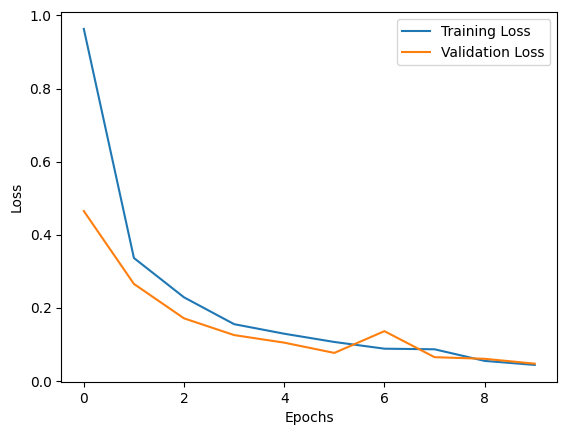

In [15]:
train_losses = history.history['loss']
val_losses = history.history['val_loss']
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [16]:
# evaluate
test_loss, test_acc = model.evaluate(test_ds)
print("Test loss:", test_loss, "Test accuracy:", test_acc)

# Save final model
final_path = "/content/drive/MyDrive/baby_movement_resnet50_final.h5"
model.save(final_path)
print("Saved model to:", final_path)


5/5 ━━━━━━━━━━━━━━━━━━━━ 50s 9s/step - accuracy: 0.9667 - loss: 0.0769


Test loss: 0.07687263190746307 Test accuracy: 0.9666666388511658
Saved model to: /content/drive/MyDrive/baby_movement_resnet50_final.h5
